In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math
from decimal import Decimal

Объявляем константы для расчётной модели

In [2]:
#constants
PEOPLE_AMOUNT = 300
STEPS_NUMBER = 100
MU = 0.3
SIGMA = 10
MIN_L = 0.4
MAX_L = 0.6
L_AMOUNT = 100
MU_AMOUNT = 30
MIN_MU = -6
MAX_MU = 2.5
SAME_VALUE_BALANCE = 5

Создаём выборку случайных чисел с распределением Гаусса

In [3]:
def generateGaussRandomArray(mu, sigma):
    return np.random.normal(mu, sigma, PEOPLE_AMOUNT)

Создаём выборку из одинаковых значений

In [4]:
def generateSameRandomValue():
    return np.array(np.full(PEOPLE_AMOUNT, SAME_VALUE_BALANCE), dtype=np.dtype(Decimal))

Получаем начальные значения для капиталов людей

In [5]:
balances = generateGaussRandomArray(MU, SIGMA)
#balances = generateSameRandomValue()

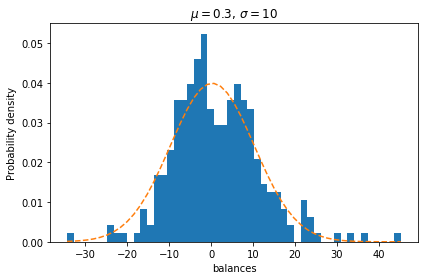

In [6]:
# example data
mu = MU  # mean of distribution
sigma = SIGMA  # standard deviation of distribution
x = balances

num_bins = 50

fig, ax = plt.subplots()

# the histogram of the data
n, bins, patches = ax.hist(x, num_bins, density=1)

# add a 'best fit' line
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax.plot(bins, y, '--')
ax.set_xlabel('balances')
ax.set_ylabel('Probability density')
ax.set_title(r'$\mu=0.3$, $\sigma=10$')

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()

определяем функцию $f(C_i) = ln(e^{C_i} + 1)$

In [7]:
def balanceFunction(balance):
    res = np.array([])
    for b in balances:
        bDecimal = Decimal(b)
        res = np.append(res, (bDecimal.exp() + Decimal(1)).ln())
    return res

определяем функцию $f(C_i) = \frac{{C_i}^3}{{C_i}^2 + e^{-x}}$

In [8]:
def balanceFunction2(balance):
    res = np.array([])
    for b in balances:
        bDecimal = Decimal(b)
        res = np.append(res, bDecimal**3/(bDecimal**2 + (-bDecimal).exp()))
    return res

Определяем изменение капитала отедльного человека как функцию $g(C_i, c_i) = c_i \cdot (\frac{a}{|\mu|} \cdot f(C_i) + 1)$

In [9]:
def balanceIncrementFunctionForPerson(balance, personalSuggestion, mu, a):
    b = balanceFunction(balance)
    res = np.array([])
    for i in range(0, PEOPLE_AMOUNT):
        res = np.append(res, Decimal(personalSuggestion[i]) * (Decimal(a) / Decimal(abs(mu)) * Decimal(b[i]) + Decimal(1)))
    return res

def balanceIncrementFunction(balances, suggestions, mu, a):
    return balanceIncrementFunctionForPerson(balances, suggestions, mu, a)

Определяем набор предложений

In [10]:
suggestionsList = np.array([])
for i in range(0, STEPS_NUMBER):
    sug = generateGaussRandomArray(MU, SIGMA)
    suggestionsList = np.append(suggestionsList, sug)
suggestionsList = suggestionsList.reshape(-1, PEOPLE_AMOUNT)

Функция, проверяющая, принимает общество отдельное предложение или нет

In [11]:
def isSolutionApplyed(increments, l):
    sum = 0
    for i in range(0, increments.size):
        if increments[i] > 0:
            sum = sum + 1
    return sum >= l * PEOPLE_AMOUNT

In [12]:
# @technical
# Returns sum of arrays with dtype = decimal 
def sumDecimalArray(newBalances, increments):
    resList = np.array([])
    for i in range(0, PEOPLE_AMOUNT):
        incr = increments[i]
        b = newBalances[i]
        res = Decimal(incr) + Decimal(b)
        resList = np.append(resList, res)
    return resList

Функция, возвращающая капитал общества и процент принятых предложений по входным параметрам:
			* balances - текущий капитал каждого человека (набор значений капиталов всех людей в обществе)
			* l - порог принятия решения
			* a - параметр функции изменения капитала человека

In [13]:
def updateBalances(balances, l, a, mu):
    newBalances = balances
    sum = 0
    for suggestions in suggestionsList:
        increments = balanceIncrementFunction(newBalances, suggestions, mu, a)
        if isSolutionApplyed(increments, l):
            sum = sum + 1
            newBalances = sumDecimalArray(newBalances, increments)
    return newBalances, sum/STEPS_NUMBER

Набор значений порога принятия решения

In [14]:
arrayL = np.linspace(MIN_L, MAX_L, L_AMOUNT)

In [15]:
# @technical
# Returns average mean of array items with dtype = decimal 
def decimalAverage(array):
    result = 0
    for item in array:
        result = Decimal(result) + Decimal(item)
    return result/PEOPLE_AMOUNT

Функция, которая возвращает среднее изменение капитала человека в обществе после принятия набора предложений. Функция изменения капитала человека с параметром a

In [16]:
def calcBalancesForLimitsRangeAndParametrA(a):
    avrBalances = np.array([])
    positive = np.array([])
    for l in arrayL:
        tempBalances, positivePercentage = updateBalances(balances, l, a, MU)
        avrBalances = np.append(avrBalances, decimalAverage(tempBalances) - decimalAverage(balances))
        positive = np.append(positive, positivePercentage)
    return avrBalances, positive

Считаем средние значения изменения капитала человека с функцией изменения капитала с параметром a. Рассматриваем три значения параметра a: 0.1, 0.5, 0.9

In [17]:
avrBalancesForL = np.array([])
positiveList = np.array([])
for a in [0.1, 0.5, 0.9]:
    avrBalances, positive = calcBalancesForLimitsRangeAndParametrA(a)
    avrBalancesForL = np.append(avrBalancesForL, avrBalances)
    positiveList = np.append(positiveList, positive)

avrBalancesForL = avrBalancesForL.reshape(-1, L_AMOUNT)
positiveList = positiveList.reshape(-1, L_AMOUNT)

# Графики приращения капитала человека для разных пороговых значений принятия решения

In [18]:
def annot_max(x,y, ax):
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text= "x={:.3f}, y={:.3f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)

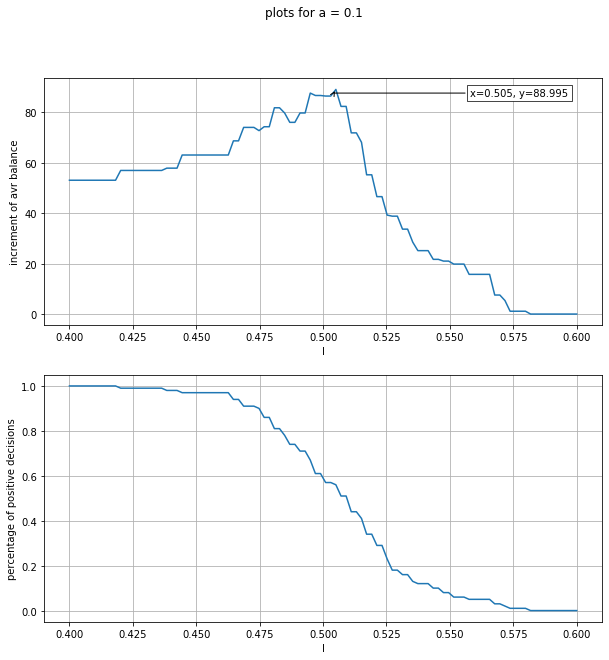

In [19]:
fig, axs = plt.subplots(2, figsize=(10,10))
fig.suptitle('plots for a = 0.1')
axs[0].plot(arrayL, avrBalancesForL[0])
axs[0].set_xlabel('l')
axs[0].set_ylabel('increment of avr balance')
axs[0].grid()
annot_max(arrayL, avrBalancesForL[0], axs[0])
axs[1].plot(arrayL, positiveList[0])
axs[1].set_xlabel('l')
axs[1].set_ylabel('percentage of positive decisions')
axs[1].grid()

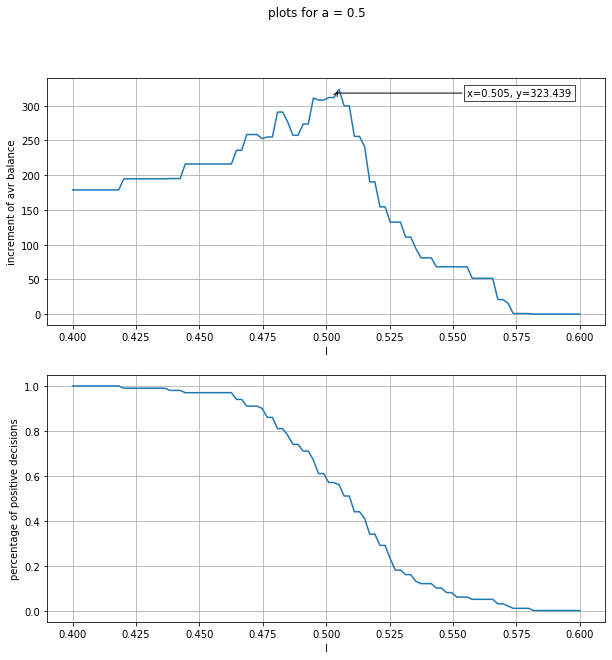

In [20]:
fig, axs = plt.subplots(2, figsize=(10,10))
fig.suptitle('plots for a = 0.5')
axs[0].plot(arrayL,avrBalancesForL[1])
axs[0].set_xlabel('l')
axs[0].set_ylabel('increment of avr balance')
axs[0].grid()
annot_max(arrayL, avrBalancesForL[1], axs[0])
axs[1].plot(arrayL, positiveList[1])
axs[1].set_xlabel('l')
axs[1].set_ylabel('percentage of positive decisions')
axs[1].grid()

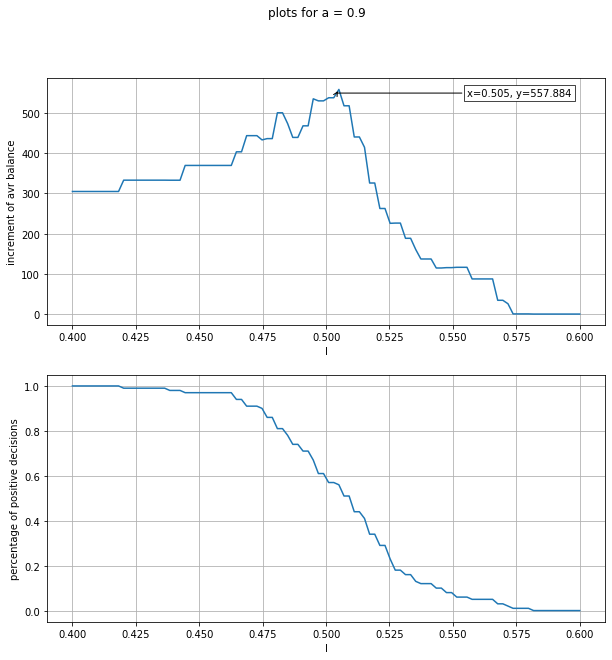

In [21]:
fig, axs = plt.subplots(2, figsize=(10,10))
fig.suptitle('plots for a = 0.9')
axs[0].plot(arrayL,avrBalancesForL[2])
axs[0].set_xlabel('l')
axs[0].set_ylabel('increment of avr balance')
axs[0].grid()
annot_max(arrayL, avrBalancesForL[2], axs[0])
axs[1].plot(arrayL, positiveList[2])
axs[1].set_xlabel('l')
axs[1].set_ylabel('percentage of positive decisions')
axs[1].grid()

# Зависимость оптимального порога голосования от $\mu$

In [ ]:
def getXMax(x,y):
    xmax = x[np.argmax(y)]
    return xmax

In [ ]:
def generateSuggestionsList(mu, sigma):
    suggestionsList = np.array([])
    for i in range(0, STEPS_NUMBER):
        sug = generateGaussRandomArray(mu, sigma)
        suggestionsList = np.append(suggestionsList, sug)
    return suggestionsList.reshape(-1, PEOPLE_AMOUNT)

Функция, возвращающая капитал общества и процент принятых предложений по входным параметрам:
			* balances - текущий капитал каждого человека (набор значений капиталов всех людей в обществе)
			* l - порог принятия решения
			* a - параметр функции изменения капитала человека

In [ ]:
def updateBalancesPro(balances, l, a, mu, suggestionsList):
    newBalances = balances
    for suggestions in suggestionsList:
        increments = balanceIncrementFunction(newBalances, suggestions, mu, a)
        if isSolutionApplyed(increments, l):
            newBalances = sumDecimalArray(newBalances, increments)
    return newBalances

In [ ]:
arrayMu = np.linspace(MIN_MU, MAX_MU, MU_AMOUNT)

In [ ]:
def calcBalancesForLimitRangeAndParametrAPro(a, mu, suggestionsList):
    avrBalances = np.array([])
    positive = np.array([])
    for l in arrayL:
        tempBalances = updateBalancesPro(balances, l, a, mu, suggestionsList)
        avrBalances = np.append(avrBalances, decimalAverage(tempBalances) - decimalAverage(balances))
    return getXMax(arrayL, avrBalances)

In [ ]:
xMaxArray = np.array([])
for m in arrayMu:
    suggestionsList = generateSuggestionsList(m, SIGMA)
    xMaxArray = np.append(xMaxArray, calcBalancesForLimitRangeAndParametrAPro(0.5, m, suggestionsList))

In [ ]:
fig, axs = plt.subplots(1, figsize=(10,10))
fig.suptitle('plot for a = 0.5')
axs.plot(arrayMu, xMaxArray)
axs.set_xlabel('$\mu$')
axs.set_ylabel('l')
axs.grid()
annot_max(arrayMu, xMaxArray, axs)

# Рассмотрим общество с одинаковыми начальными капиталами у эгоистов

In [ ]:
SAME_VALUE_BALANCE3 = 100

In [ ]:
def generateSameRandomValue3():
    return np.array(np.full(PEOPLE_AMOUNT, SAME_VALUE_BALANCE3), dtype=np.dtype(Decimal))

Получаем начальные значения для капиталов людей

In [ ]:
balances = generateSameRandomValue3()
print(balances)

In [ ]:
# example data
mu = MU  # mean of distribution
sigma = SIGMA  # standard deviation of distribution
x = balances
num_bins = 50

fig, ax = plt.subplots()
ax.set_xlabel('balances')
ax.set_ylabel('Probability density')
ax.set_title(r'the same value of balance of egoists')
# the histogram of the data
n, bins, patches = ax.hist(x, num_bins, density=1)

plt.show()

определяем функцию $f(C_i) = ln(e^{C_i} + 1)$

In [ ]:
def balanceFunction3(balance):
    res = np.array([])
    for b in balances:
        bDecimal = Decimal(b)
        res = np.append(res, (bDecimal.exp() + Decimal(1)).ln())
    return res

Определяем изменение капитала отедльного человека как функцию $g(C_i, c_i) = c_i \cdot (\frac{a}{|\mu|} \cdot f(C_i) + 1)$

In [ ]:
def balanceIncrementFunctionForPerson3(balance, personalSuggestion, mu, a):
    b = balanceFunction2(balance)
    res = np.array([])
    for i in range(0, PEOPLE_AMOUNT):
        res = np.append(res, Decimal(personalSuggestion[i]) * (Decimal(a) / Decimal(abs(mu)) * Decimal(b[i]) + Decimal(1)))
    return res

def balanceIncrementFunction3(balances, suggestions, mu, a):
    return balanceIncrementFunctionForPerson3(balances, suggestions, mu, a)

Определяем набор предложений

In [ ]:
suggestionsList = np.array([])
for i in range(0, STEPS_NUMBER):
    sug = generateGaussRandomArray(MU, SIGMA)
    suggestionsList = np.append(suggestionsList, sug)
suggestionsList = suggestionsList.reshape(-1, PEOPLE_AMOUNT)

In [ ]:
# example data
mu = MU  # mean of distribution
sigma = SIGMA  # standard deviation of distribution
x = suggestionsList[0]
num_bins = 50

fig, ax = plt.subplots()
ax.set_xlabel('balances')
ax.set_ylabel('Probability density')
ax.set_title(r'$\mu=0.3$, $\sigma=10$')
# the histogram of the data
n, bins, patches = ax.hist(x, num_bins, density=1)

plt.show()

Функция, проверяющая, принимает общество отдельное предложение или нет

In [ ]:
def isSolutionApplyed3(increments, l):
    sum = 0
    for i in range(0, increments.size):
        if increments[i] > 0:
            sum = sum + 1
    return sum >= l * PEOPLE_AMOUNT

In [ ]:
# @technical
# Returns sum of arrays with dtype = decimal 
def sumDecimalArray3(newBalances, increments):
    resList = np.array([])
    for i in range(0, PEOPLE_AMOUNT):
        incr = increments[i]
        b = newBalances[i]
        res = Decimal(incr) + Decimal(b)
        resList = np.append(resList, res)
    return resList

Функция, возвращающая капитал общества и процент принятых предложений по входным параметрам:
			* balances - текущий капитал каждого человека (набор значений капиталов всех людей в обществе)
			* l - порог принятия решения
			* a - параметр функции изменения капитала человека

In [ ]:
def updateBalances3(balances, a, mu, l, suggestionsList):
    newBalances = balances
    for suggestions in suggestionsList:
        increments = balanceIncrementFunction3(newBalances, suggestions, mu, a)
        if isSolutionApplyed3(increments, l):
            newBalances = sumDecimalArray3(newBalances, increments)
    return newBalances

In [ ]:
newBalances = updateBalances3(balances, 0.5, MU, 0.5, suggestionsList)

In [ ]:
# example data
mu = MU  # mean of distribution
sigma = SIGMA  # standard deviation of distribution
x = np.array(newBalances, dtype=float)

num_bins = 50

fig, ax = plt.subplots()

# the histogram of the data
n, bins, patches = ax.hist(x, num_bins, density=1)
ax.set_xlabel('balances')
ax.set_ylabel('probability density')
ax.set_title(r'initial balance $= 5$; $l = 0.5$; $a = 0.5$')

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()